## Comparing SVs from cenHap4 derived from centrolign induced pairwise and Fedor's HorHap analysis

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file"])


In [10]:
horhap_beds="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/fedor_horHap_SV_beds"
cen_beds="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/SV_beds_asm_coords"
horhap_svs = read_sv_bed_files("cenhap4", horhap_beds)
centrolign_svs=read_sv_bed_files("cenhap4", cen_beds)

pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/chr12_r2_QC_v2_centrolign_pairwise_distance.csv"

Found 1711 SV bed files for clade 'cenhap4'
Found 1485 SV bed files for clade 'cenhap4'


In [5]:
### Sanity check: missing samples 

# Convert each row to a frozenset (unordered pair)
pairs1 = set(centrolign_svs.apply(lambda row: frozenset([row["sample1"], row["sample2"]]), axis=1))
pairs2 = set(horhap_svs.apply(lambda row: frozenset([row["sample1"], row["sample2"]]), axis=1))

# Pairs missing in df2
missing_in_df2 = pairs1 - pairs2
print("Pairs in df1 but missing in df2:", missing_in_df2)

# Pairs missing in df1
missing_in_df1 = pairs2 - pairs1
print("Pairs in df2 but missing in df1:", missing_in_df1)

### Reason we are missing samples is that Fedor is using the full HPRC list, so some samples from his list
### were excluded in our QC 

Pairs in df1 but missing in df2: set()
Pairs in df2 but missing in df1: {frozenset({'NA19682.1', 'HG01261.2'}), frozenset({'HG02976.2', 'HG01150.1'}), frozenset({'HG02698.2', 'HG02486.2'}), frozenset({'HG01530.2', 'HG01261.2'}), frozenset({'HG01530.2', 'NA21106.2'}), frozenset({'NA20870.1', 'HG01261.2'}), frozenset({'NA21106.2', 'HG02486.2'}), frozenset({'HG00344.2', 'HG01261.2'}), frozenset({'HG01175.1', 'HG01261.2'}), frozenset({'HG00320.1', 'HG01261.2'}), frozenset({'NA21102.2', 'HG01261.2'}), frozenset({'NA19682.2', 'HG02486.2'}), frozenset({'HG01530.2', 'HG00140.2'}), frozenset({'HG01530.2', 'NA21106.1'}), frozenset({'HG02976.2', 'HG01891.1'}), frozenset({'NA19835.1', 'HG02486.2'}), frozenset({'HG02976.2', 'HG02698.2'}), frozenset({'HG00329.2', 'HG01261.2'}), frozenset({'HG02486.2', 'HG00140.2'}), frozenset({'HG00290.2', 'HG02486.2'}), frozenset({'HG02976.2', 'HG01993.2'}), frozenset({'HG01940.2', 'HG01261.2'}), frozenset({'NA20905.1', 'HG01530.2'}), frozenset({'HG01358.1', 'HG012

In [6]:
### Sanity check - are the same samples used as ref-query in both SV sets?
# Create a combined pair key for clarity
# Create (sample1, sample2) pair tuples
pairs1 = list(zip(centrolign_svs["sample1"], centrolign_svs["sample2"]))
pairs2 = list(zip(horhap_svs["sample1"], horhap_svs["sample2"]))

# Compute sets for easy comparison
set1 = set(pairs1)
set2 = set(pairs2)
set2_rev = set((b, a) for a, b in set2)

# Determine relationships
same_order = set1 & set2
reversed_order = set1 & set2_rev
unique_to_df1 = set1 - set2 - set2_rev
unique_to_df2 = set2 - set1 - set((b, a) for a, b in set1)

# Print counts
print(f"Total pairs in df1: {len(set1)}")
print(f"Total pairs in df2: {len(set2)}")
print(f"Pairs matching in same order: {len(same_order)}")
print(f"Pairs matching in reversed order: {len(reversed_order)}")
print(f"Pairs unique to df1: {len(unique_to_df1)}")
print(f"Pairs unique to df2: {len(unique_to_df2)}")

# Print first few reversed pairs
print("First few reversed pairs:")
for i, pair in enumerate(reversed_order):
    if i >= 5:  # limit to first 5
        break
    print(pair)


Total pairs in df1: 1485
Total pairs in df2: 1711
Pairs matching in same order: 853
Pairs matching in reversed order: 632
Pairs unique to df1: 0
Pairs unique to df2: 226
First few reversed pairs:
('HG01433.2', 'HG00344.2')
('HG01784.1', 'HG01255.2')
('NA18976.2', 'HG02280.2')
('NA21102.2', 'NA18976.2')
('HG04228.2', 'HG00232.2')


In [9]:
# Create order-independent pair key for both dataframes
df1=horhap_svs
df2=centrolign_svs

df1["pair_key"] = df1.apply(lambda r: "_".join(sorted([r["sample1"], r["sample2"]])), axis=1)
df2["pair_key"] = df2.apply(lambda r: "_".join(sorted([r["sample1"], r["sample2"]])), axis=1)

# Get set of valid pairs from df2
valid_pairs = set(df2["pair_key"])

# Subset df1 to only include pairs that appear in df2 (order doesn't matter)
df1_subset = df1[df1["pair_key"].isin(valid_pairs)].copy()

# Drop helper column if not needed
df1_subset = df1_subset.drop(columns=["pair_key"])
df2 = df2.drop(columns=["pair_key"])

# --- Print summary ---
print(f"Original df1 rows: {len(df1)}")
print(f"Original df2 rows: {len(df2)}")
print(f"Subset df1 rows (matching pairs in df2): {len(df1_subset)}")

# Optional preview
print("\nSubset df1 head:")
print(df1_subset.head())

conditions = [
        ("diff_eq_-1",  (df2["diff"] == -1)),
        ("diff_lt_0.1",  (df2["diff"] < 0.1)),
        ("diff_gt_0.1",  (df2["diff"] > 0.1))
    ]
for label, cond in conditions:
    print(label)
    print(len(df2[cond]))

Original df1 rows: 160930
Original df2 rows: 460812
Subset df1 rows (matching pairs in df2): 140266

Subset df1 head:
     sample1    start1      end1    sample2    start2      end2 type  diff  \
0  HG00320.1  34713122  34721091  HG03804.2  34819919  34819920    D     6   
1  HG00320.1  34762819  34765422  HG03804.2  34861181  34861182    D     2   
2  HG00320.1  34773574  34786042  HG03804.2  34869178  34869179    D     8   
3  HG00320.1  34797010  34798006  HG03804.2  34879708  34879709    D     1   
4  HG00320.1  34813310  34830295  HG03804.2  34895333  34895334    D    12   

     clade              source_file  length  
0  cenhap4  HG00320.1_HG03804.2.bed    7969  
1  cenhap4  HG00320.1_HG03804.2.bed    2603  
2  cenhap4  HG00320.1_HG03804.2.bed   12468  
3  cenhap4  HG00320.1_HG03804.2.bed     996  
4  cenhap4  HG00320.1_HG03804.2.bed   16985  
diff_eq_-1
247417
diff_lt_0.1
318321
diff_gt_0.1
142491


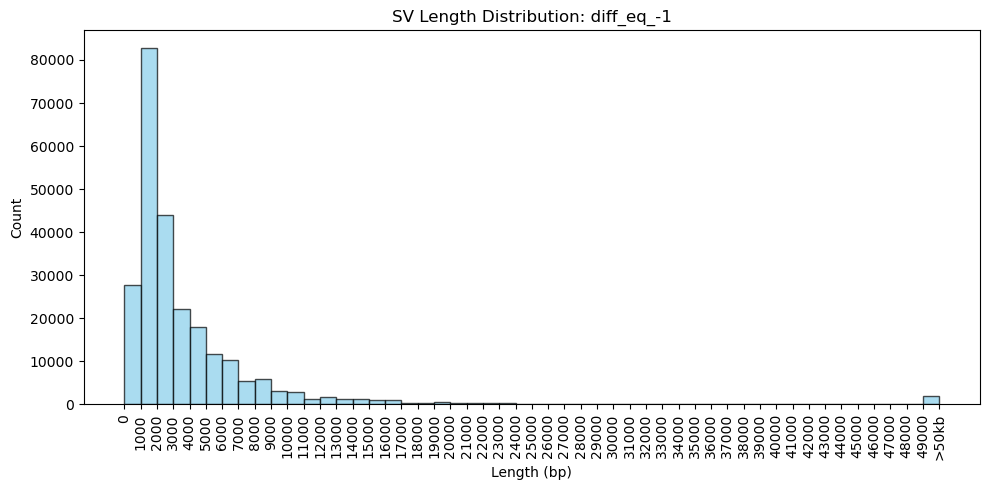

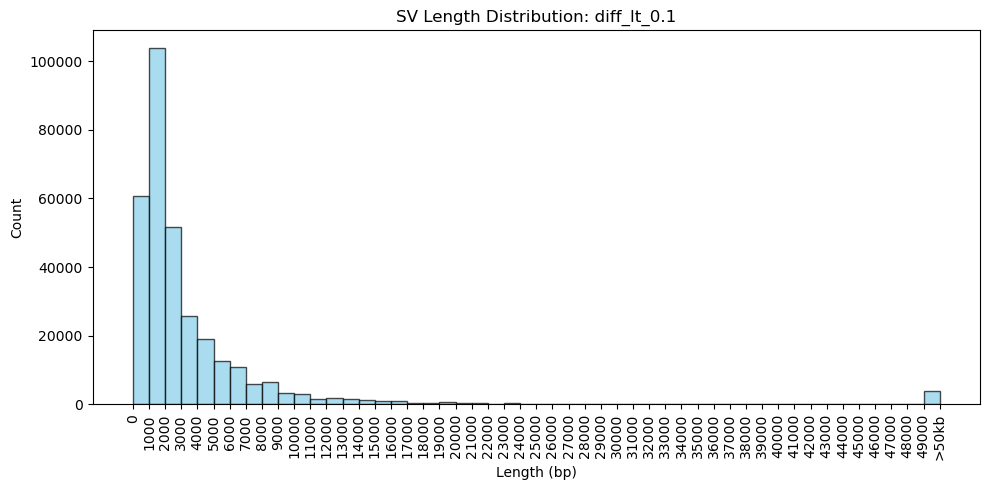

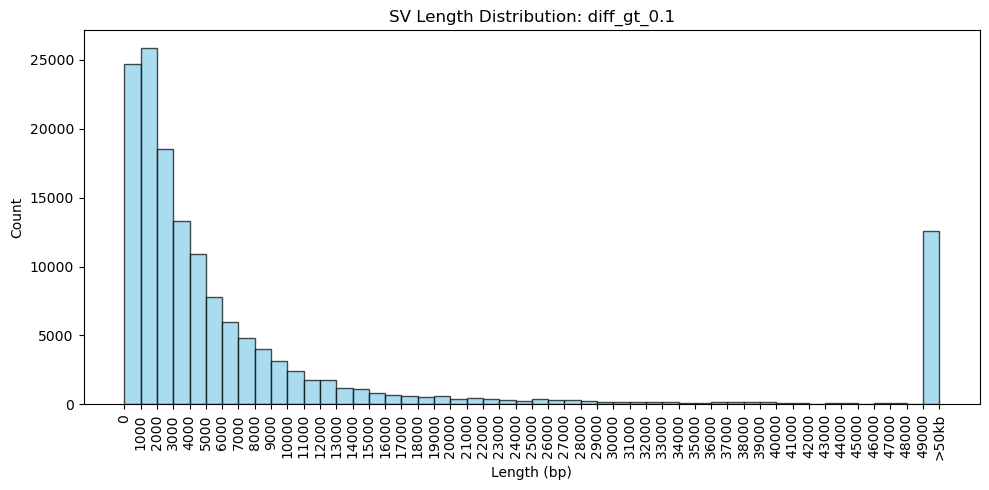

No SVs found for diff_eq_-1 within given size range.
No SVs found for diff_lt_0.1 within given size range.


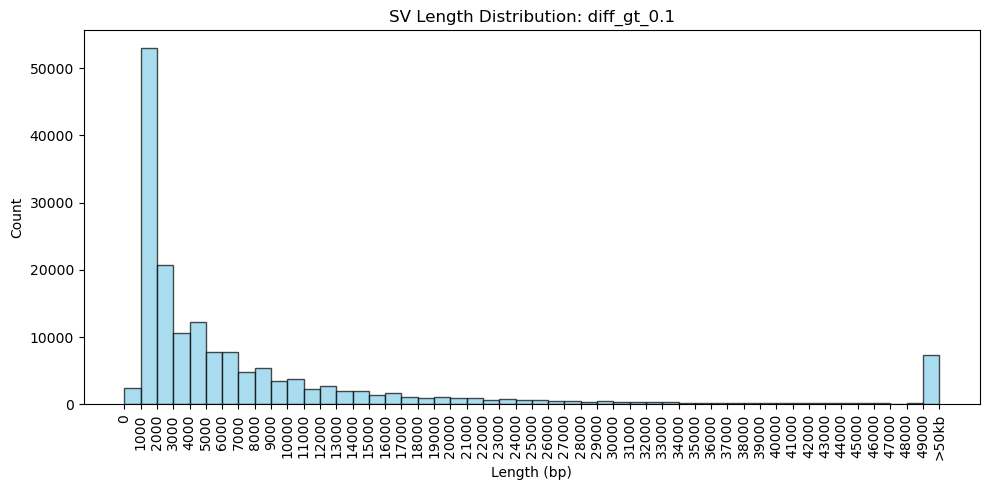

In [10]:
# Plot SV length distributions for HoRHap SVs and Centrolign SV 
def plot_length_distributions(df, output_prefix, min_sv=None, max_sv=None, bin_size=1000, max_bin=50000
):
    """
    Generate SV length histograms with configurable filtering and binning.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: 'type', 'diff', and 'length'.
    output_prefix : str
        File path prefix for saving plots.
    min_sv : int, optional
        Minimum SV length (bp) to include in the plot. Default = None (no lower limit).
    max_sv : int, optional
        Maximum SV length (bp) to include in the plot. Default = None (no upper limit).
    bin_size : int, optional
        Size of each histogram bin in base pairs. Default = 1000.
    max_bin : int, optional
        Maximum bin cutoff; all SVs >= max_bin are grouped into the final bin. Default = 50,000 bp.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # Ensure directory exists
    out_dir = os.path.dirname(output_prefix)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Define filter conditions
    conditions = [
        ("diff_eq_-1",  (df["diff"] == -1)),
        ("diff_lt_0.1",  (df["diff"] < 0.1)),
        ("diff_gt_0.1",  (df["diff"] > 0.1))
    ]

    for label, cond in conditions:
        subset = df[cond].copy()

        # Apply SV size filtering if requested
        if min_sv is not None:
            subset = subset[subset["length"] >= min_sv]
        if max_sv is not None:
            subset = subset[subset["length"] <= max_sv]

        if subset.empty:
            print(f"No SVs found for {label} within given size range.")
            continue

        # Cap lengths at max_bin for plotting/counting
        lengths = subset["length"].copy()
        lengths_capped = np.where(lengths >= max_bin, max_bin, lengths)

        # Define bins
        bin_start = min_sv if min_sv is not None else 0
        bins = np.arange(bin_start, max_bin + bin_size, bin_size)
        counts, bin_edges = np.histogram(lengths_capped, bins=bins)

        # Count SVs >= max_bin separately and add to final bin
        overflow_count = (lengths >= max_bin).sum()
        counts[-1] += overflow_count

        # Print bin counts
        # print(f"\n=== {label} ===")
        # print("Bin range (bp) | Count")
        # for i in range(len(counts) - 1):
        #     print(f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)} | {counts[i]}")
        # print(f">={max_bin}| {overflow_count}")

        # Plot histogram
        plt.figure(figsize=(10, 5))
        x_pos = bin_edges[:-1]

        plt.bar(
            x_pos,
            counts,
            width=bin_size,
            align='edge',
            color="skyblue",
            edgecolor="black",
            alpha=0.7
        )

        # Label x-axis
        x_labels = [str(int(edge)) for edge in bin_edges[:-1]] + [f">{max_bin/1000:.0f}kb"]
        plt.xticks(list(x_pos) + [max_bin], x_labels, rotation=90)

        plt.title(f"SV Length Distribution: {label}")
        plt.xlabel("Length (bp)")
        plt.ylabel("Count")
        plt.tight_layout()

        output_file = f"{output_prefix}_{label}.png"
        #plt.savefig(output_file)
        #plt.close()
        plt.show()
        #print(f"Saved plot: {output_file}")


#plot_length_distributions(merged_df, plot_prefix+"all_SVs")
#plot_length_distributions(merged_df, plot_prefix+"SVs_1kb_2kb",min_sv=1000,max_sv=2000,bin_size=20,max_bin=2000)
plot_length_distributions(centrolign_svs, "SVs_1150_2kb")
plot_length_distributions(horhap_svs, "SVs_1150_2kb")

In [11]:
def export_sv_bed(df, output_path,reversed_pairs=None):
    """
    Create BED files from an SV dataframe.

    If `reversed_pairs` is provided (as a set of (sample1, sample2) tuples),
    any matching rows will:
      - swap sample1/start1/end1 with sample2/start2/end2
      - flip type: "I" <-> "D"

    Output:
      <output_path>_del.bed
      <output_path>_ins.bed
    """

    df = df.copy()

     # --- Handle reversed pairs if provided ---
    if reversed_pairs:
        for idx, row in df.iterrows():
            pair = (row["sample1"], row["sample2"])
            if pair in reversed_pairs:
                # Swap sample1/start1/end1 with sample2/start2/end2
                df.at[idx, "sample1"], df.at[idx, "sample2"] = row["sample2"], row["sample1"]
                df.at[idx, "start1"], df.at[idx, "start2"] = row["start2"], row["start1"]
                df.at[idx, "end1"], df.at[idx, "end2"] = row["end2"], row["end1"]

                # Flip type: insertion <-> deletion
                if row["type"] == "I":
                    df.at[idx, "type"] = "D"
                elif row["type"] == "D":
                    df.at[idx, "type"] = "I"

    # Create a consistent sample pair name
    df["sample_pair"] = df.apply(
        lambda row: "_".join(sorted([row["sample1"], row["sample2"]])), axis=1
    )

    # Separate insertions and deletions
    ins = df[df["type"] == "I"].copy()
    dels = df[df["type"] == "D"].copy()

    # For insertions: take sample2 coordinates
    ins_bed = ins.rename(columns={
        "start2": "start", "end2": "end"
    })[["sample_pair", "start", "end", "type", "diff"]]

    # For deletions: take sample1 coordinates
    del_bed = dels.rename(columns={
        "start1": "start", "end1": "end"
    })[["sample_pair", "start", "end", "type", "diff"]]

    del_bed_df = del_bed.sort_values(["sample_pair", "start", "end"])
    ins_bed_df = ins_bed.sort_values(["sample_pair", "start", "end"])

    # Save as tab-separated BED
    del_bed_df.to_csv(output_path+"_del.bed", sep="\t", header=False, index=False)
    ins_bed_df.to_csv(output_path+"_ins.bed", sep="\t", header=False, index=False)

    print(f"BED file written to: {del_bed_df}")
    print(del_bed_df.head())  # preview a few rows
    print(f"BED file written to: {ins_bed_df}")
    print(ins_bed_df.head())  # preview a few rows

    return 

export_sv_bed(centrolign_svs,"/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/centrolign_SVs",reversed_pairs=reversed_order)
export_sv_bed(horhap_svs,"/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/horhap_SVs")

# spot checked a few to make sure the reversing was correct 

BED file written to:                sample_pair     start       end type      diff
8163   HG00099.1_HG00126.2  34651801  34652930    D  0.546222
8165   HG00099.1_HG00126.2  34683917  34688668    D  0.176603
8167   HG00099.1_HG00126.2  34696343  34698379    D  0.667485
8169   HG00099.1_HG00126.2  34699194  34702408    D  0.845675
8171   HG00099.1_HG00126.2  34702992  34703066    D  0.991006
...                    ...       ...       ...  ...       ...
48530  NA21106.1_NA21106.2  37608802  37614011    D  0.458749
48534  NA21106.1_NA21106.2  37619998  37644451    D  0.416800
48535  NA21106.1_NA21106.2  37644477  37645834    D -1.000000
48536  NA21106.1_NA21106.2  37648051  37650764    D -1.000000
48538  NA21106.1_NA21106.2  37664677  37666713    D -1.000000

[232805 rows x 5 columns]
              sample_pair     start       end type      diff
8163  HG00099.1_HG00126.2  34651801  34652930    D  0.546222
8165  HG00099.1_HG00126.2  34683917  34688668    D  0.176603
8167  HG00099.1_HG00126.2

### Using bedtools coverage results, plot percent overlap (Percent of centrolign SV overlapped by HorHap SV)

In [12]:
bed_path = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/bedtools_coverage_del_ins.bed"

# Define the column names in order
columns = ["pair", "start", "end", "type","length_diff",
    "coverage_depth", "num_bases_at_depth", "size_of_A", "perc_of_A_at_depth"]

# Read the file (tab-separated, no header in the BED file)
bed_cov_df = pd.read_csv(bed_path, sep="\t", header=None, names=columns)

# compute sv length
bed_cov_df["sv_length"] = bed_cov_df["end"] - bed_cov_df["start"]
print(bed_cov_df.head())
# Split by type
df_ins = bed_cov_df[bed_cov_df["type"] == "I"]
df_del = bed_cov_df[bed_cov_df["type"] == "D"]

                  pair     start       end type  length_diff  coverage_depth  \
0  HG00099.1_HG00126.2  34651801  34652930    D     0.546222               0   
1  HG00099.1_HG00126.2  34683917  34688668    D     0.176603               0   
2  HG00099.1_HG00126.2  34696343  34698379    D     0.667485               0   
3  HG00099.1_HG00126.2  34699194  34702408    D     0.845675               0   
4  HG00099.1_HG00126.2  34702992  34703066    D     0.991006               0   

   num_bases_at_depth  size_of_A  perc_of_A_at_depth  sv_length  
0                   0       1129                 0.0       1129  
1                   0       4751                 0.0       4751  
2                   0       2036                 0.0       2036  
3                   0       3214                 0.0       3214  
4                   0         74                 0.0         74  


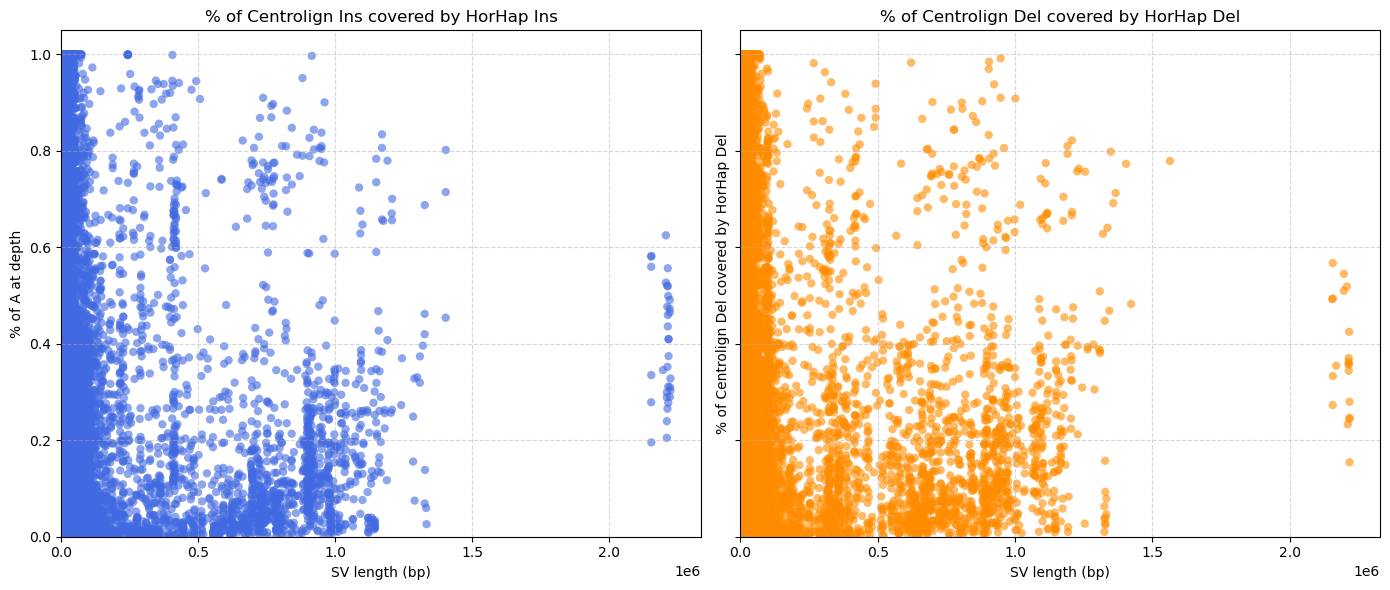

In [13]:
# --- Create the plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Insertions (I)
axes[0].scatter(df_ins["sv_length"], df_ins["perc_of_A_at_depth"],
                color="royalblue", alpha=0.6, edgecolor="none")
axes[0].set_title("% of Centrolign Ins covered by HorHap Ins")
axes[0].set_xlabel("SV length (bp)")
axes[0].set_ylabel("% of A at depth")

# Deletions (D)
axes[1].scatter(df_del["sv_length"], df_del["perc_of_A_at_depth"],
                color="darkorange", alpha=0.6, edgecolor="none")
axes[1].set_title("% of Centrolign Del covered by HorHap Del")
axes[1].set_xlabel("SV length (bp)")
axes[1].set_ylabel("% of Centrolign Del covered by HorHap Del")

# --- Shared styling ---
for ax in axes:
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


/data/tmp/ipykernel_765553/2762567139.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_765553/2762567139.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_765553/2762567139.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_765553/2762567139.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_765553/2762567139.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_765553/2762567139.py:32: 

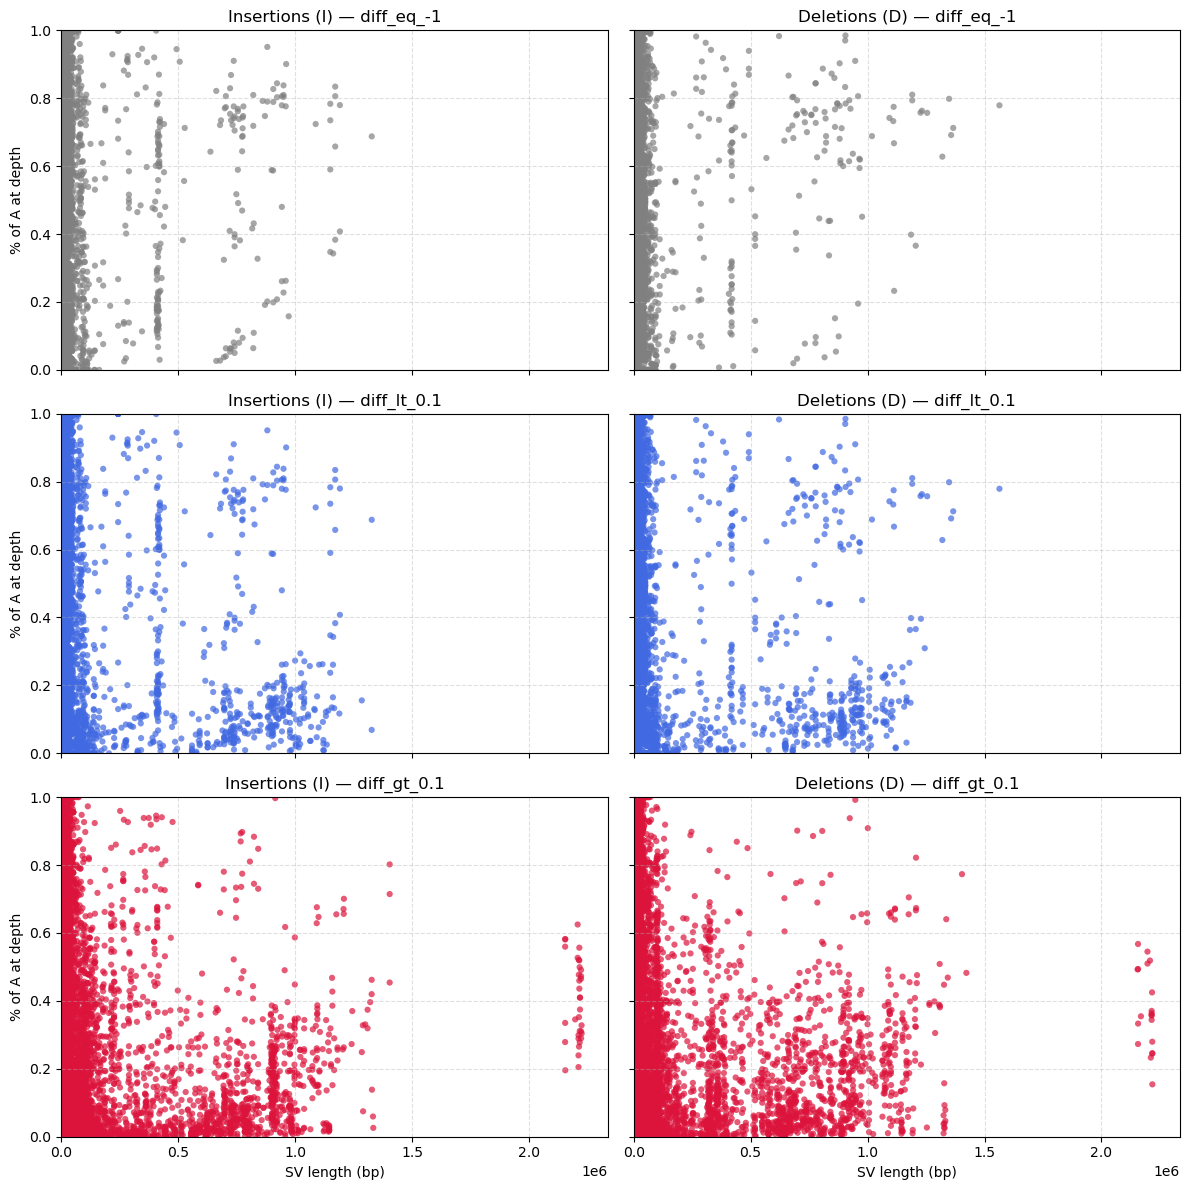

In [14]:
import matplotlib.pyplot as plt

# Define conditions
conditions = [
    ("diff_eq_-1",  (bed_cov_df["length_diff"] == -1)),
    ("diff_lt_0.1", (bed_cov_df["length_diff"] < 0.1)),
    ("diff_gt_0.1", (bed_cov_df["length_diff"] > 0.1)),
]

# Define colors for clarity
colors = {
    "diff_eq_-1": "gray",
    "diff_lt_0.1": "royalblue",
    "diff_gt_0.1": "crimson"
}

# --- Create a 3x2 grid ---
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

# --- Loop through conditions (rows) ---
for i, (label, condition) in enumerate(conditions):

    # Insertions (column 0)
    subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
    axes[i, 0].scatter(subset_I["sv_length"], subset_I["perc_of_A_at_depth"],
                       color=colors[label], alpha=0.7, s=20, edgecolor="none")
    axes[i, 0].set_title(f"Insertions (I) — {label}")
    axes[i, 0].set_ylabel("% of A at depth")
    axes[i, 0].grid(True, linestyle="--", alpha=0.4)

    # Deletions (column 1)
    subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
    axes[i, 1].scatter(subset_D["sv_length"], subset_D["perc_of_A_at_depth"],
                       color=colors[label], alpha=0.7, s=20, edgecolor="none")
    axes[i, 1].set_title(f"Deletions (D) — {label}")
    axes[i, 1].grid(True, linestyle="--", alpha=0.4)

# --- Shared axis labels ---
for ax in axes[-1, :]:
    ax.set_xlabel("SV length (bp)")

for ax in axes[:, 0]:
    ax.set_xlim(left=0)
    #ax.set_xlim(0, 500_000)
    ax.set_ylim(0, 1)
    
plt.tight_layout()
plt.show()

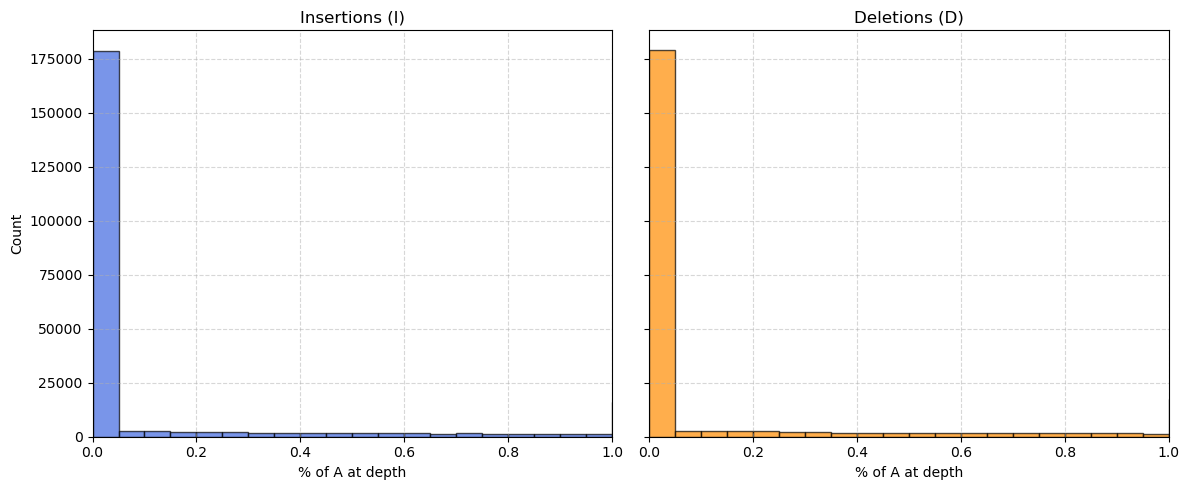

In [42]:
# --- Define histogram bins ---
bins = np.arange(0, 1.1, 0.05)  # 0 to 1 inclusive, step 0.1

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Insertions
axes[0].hist(df_ins["perc_of_A_at_depth"], bins=bins, color="royalblue", alpha=0.7, edgecolor="black")
axes[0].set_title("Insertions (I)")
axes[0].set_xlabel("% of A at depth")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 1)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Deletions
axes[1].hist(df_del["perc_of_A_at_depth"], bins=bins, color="darkorange", alpha=0.7, edgecolor="black")
axes[1].set_title("Deletions (D)")
axes[1].set_xlabel("% of A at depth")
axes[1].set_xlim(0, 1)
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

/data/tmp/ipykernel_179922/982353843.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_179922/982353843.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_179922/982353843.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_179922/982353843.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_179922/982353843.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
/data/tmp/ipykernel_179922/982353843.py:31: UserWa

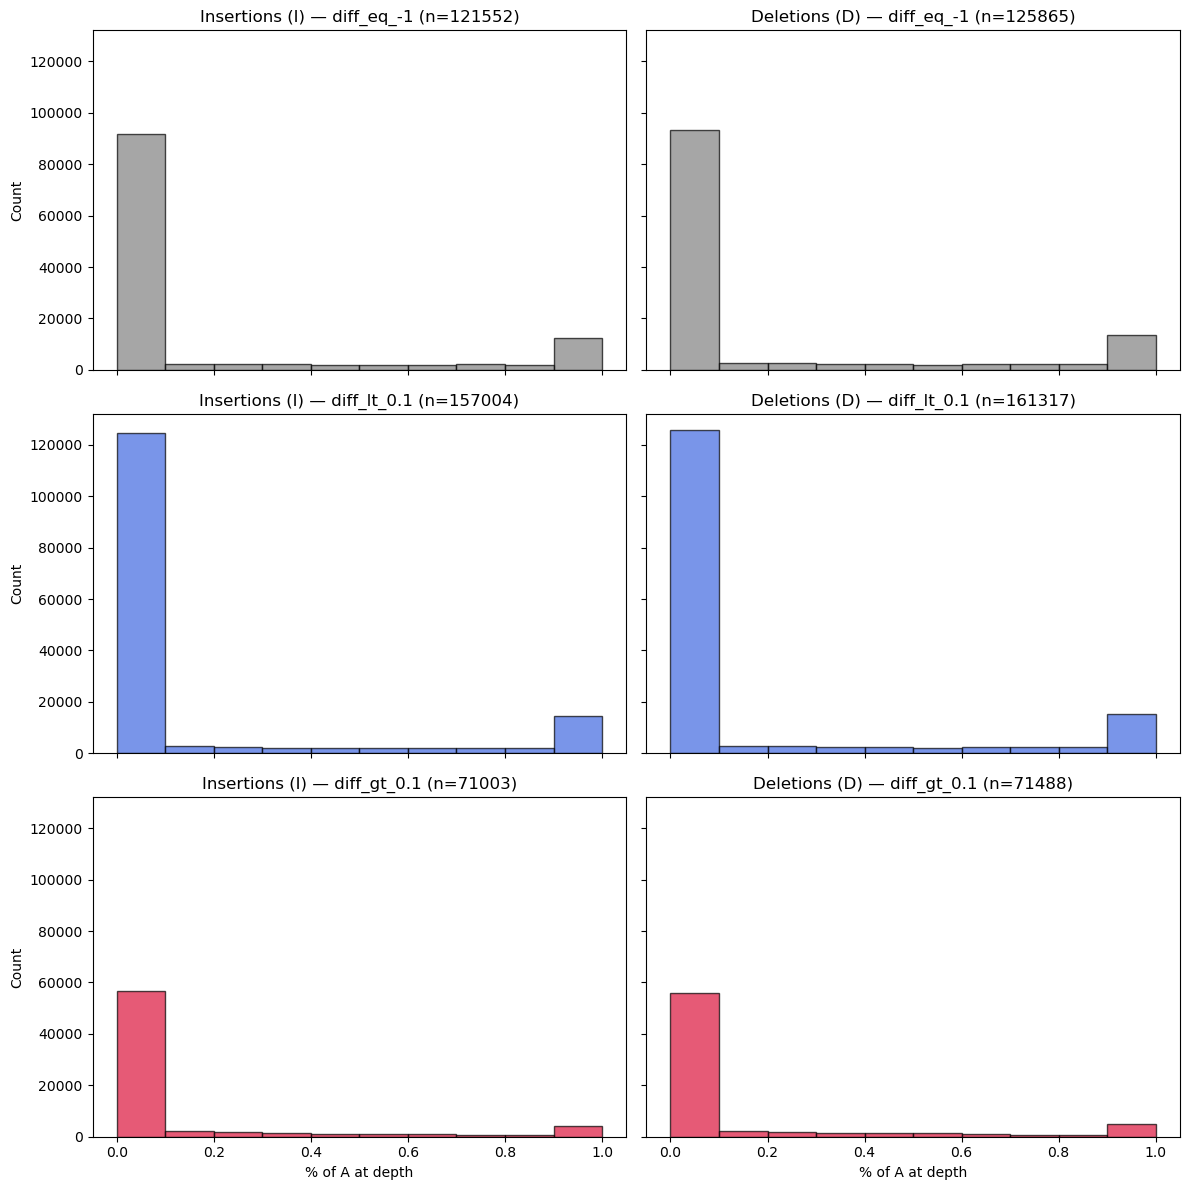

In [43]:
# Define conditions
# Define conditions
conditions = [
    ("diff_eq_-1",  (bed_cov_df["length_diff"] == -1)),
    ("diff_lt_0.1", (bed_cov_df["length_diff"] < 0.1)),
    ("diff_gt_0.1", (bed_cov_df["length_diff"] > 0.1)),
]

# Define colors for clarity
colors = {
    "diff_eq_-1": "gray",
    "diff_lt_0.1": "royalblue",
    "diff_gt_0.1": "crimson"
}
# Histogram bins
bins = np.arange(0, 1.05, 0.1)  # 0 to 1 in steps of 0.1

# --- Create 3x2 grid ---
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)

for i, (label, condition) in enumerate(conditions):

    # Insertions (column 0)
    subset_I = df_ins[condition & df_ins["perc_of_A_at_depth"].notna()]
    axes[i, 0].hist(subset_I["perc_of_A_at_depth"], bins=bins,
                     color=colors[label], alpha=0.7, edgecolor="black")
    axes[i, 0].set_title(f"Insertions (I) — {label} (n={len(subset_I)})")
    axes[i, 0].set_ylabel("Count")

    # Deletions (column 1)
    subset_D = df_del[condition & df_del["perc_of_A_at_depth"].notna()]
    axes[i, 1].hist(subset_D["perc_of_A_at_depth"], bins=bins,
                     color=colors[label], alpha=0.7, edgecolor="black")
    axes[i, 1].set_title(f"Deletions (D) — {label} (n={len(subset_D)})")

# --- Shared axis labels ---
for ax in axes[-1, :]:
    ax.set_xlabel("% of A at depth")

plt.tight_layout()
plt.show()

### Using bedtools coverage results, plot percent overlap (Percent of HORHAP SV overlapped by Centrolign SV)

In [44]:
bed_path = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/cenHap4_benchmarking_HorHaps/bedtools_coverage_del_ins_rev.bed"

# Define the column names in order
columns = ["pair", "start", "end", "type","length_diff",
    "coverage_depth", "num_bases_at_depth", "size_of_A", "perc_of_A_at_depth"]

# Read the file (tab-separated, no header in the BED file)
bed_cov_df_rev = pd.read_csv(bed_path, sep="\t", header=None, names=columns)

# compute sv length
bed_cov_df_rev["sv_length"] = bed_cov_df_rev["end"] - bed_cov_df_rev["start"]
print(bed_cov_df_rev.head())
# Split by type
df_ins = bed_cov_df_rev[bed_cov_df_rev["type"] == "I"]
df_del = bed_cov_df_rev[bed_cov_df_rev["type"] == "D"]

                  pair     start       end type  length_diff  coverage_depth  \
0  HG00099.1_HG00126.2  34714130  34735188    D           13               6   
1  HG00099.1_HG00126.2  34751152  34754546    D            2               1   
2  HG00099.1_HG00126.2  34890773  34900290    D            7               1   
3  HG00099.1_HG00126.2  34939694  34941053    D            1               1   
4  HG00099.1_HG00126.2  34984516  34989271    D            3               1   

   num_bases_at_depth  size_of_A  perc_of_A_at_depth  sv_length  
0               17019      21058            0.808196      21058  
1                3394       3394            1.000000       3394  
2                9517       9517            1.000000       9517  
3                 285       1359            0.209713       1359  
4                1359       4755            0.285804       4755  


NameError: name 'df_ins' is not defined

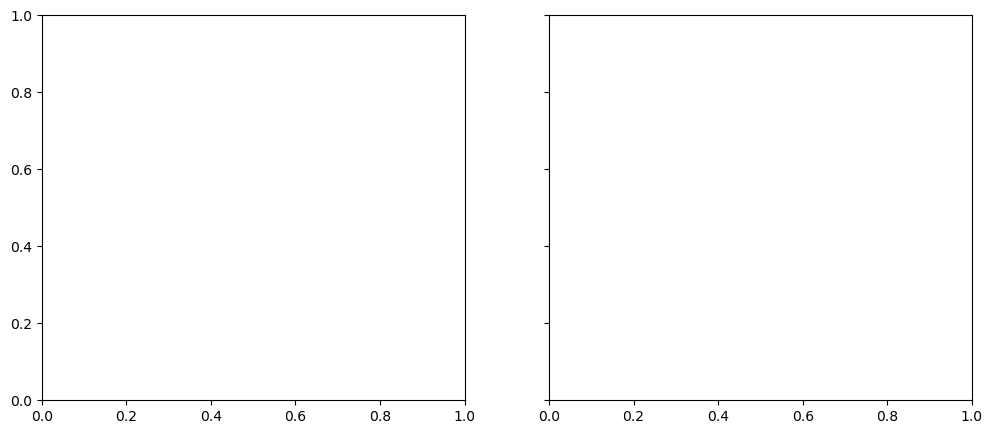

In [11]:
# --- Define histogram bins ---
bins = np.arange(0, 1.1, 0.05)  # 0 to 1 inclusive, step 0.1

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Insertions
axes[0].hist(df_ins["perc_of_A_at_depth"], bins=bins, color="royalblue", alpha=0.7, edgecolor="black")
axes[0].set_title("Insertions (I)")
axes[0].set_xlabel("% of A at depth")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 1)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Deletions
axes[1].hist(df_del["perc_of_A_at_depth"], bins=bins, color="darkorange", alpha=0.7, edgecolor="black")
axes[1].set_title("Deletions (D)")
axes[1].set_xlabel("% of A at depth")
axes[1].set_xlim(0, 1)
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# read in pairwise distances 
column_names = ['sample1', 'sample2', 'pairwise_dist']
dist_df = pd.read_csv(pairwise_dist,header=None,names=column_names)  # sample1, sample2, dist
dist_df.head()

# Make sure both dataframes are order-independent for sample pairs
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = merged_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2'], how='left')

df_sv_sorted.head()